<a href="https://colab.research.google.com/github/zvkong/stats-8330/blob/main/Homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages('caret')

In [ ]:
install.packages('tidyverse')

In [ ]:
install.packages('ggplot2')
devtools::install_github("rstudio/keras")
install.packages('gbm')

In [213]:
library(ggplot2);library(keras);library(gbm);library(caret);library(tidyverse)

Boosting

In [214]:
bhouse = read.table('housingdata')
# making training and test, 85% training and 15% testing
train = sample(1:nrow(bhouse), round(nrow(bhouse)*0.85))
train.bhouse = bhouse[train,]
test.bhouse = bhouse[-train,]

In [228]:
set.seed(1)
ctrl <- trainControl(
  method = "cv",
  number = 5
)
fit <- train(V14 ~ ., 
                    data = train.bhouse,
                    method = 'gbm',
                    preProcess = c("center", "scale"),
                    trControl = ctrl,
                    verbose = FALSE)
#fit
#fit$result[which.min(fit$results$RMSE),4]
#fit$result[which.min(fit$results$RMSE),2]

In [230]:
boost.bhouse = gbm(V14 ~. -V14, data = train.bhouse, distribution = 'gaussian',n.trees = fit$result[which.min(fit$results$RMSE),4],
                  interaction.dept=fit$result[which.min(fit$results$RMSE),2])
yhat = predict(boost.bhouse, test.bhouse, interaction.dept=fit$result[which.min(fit$results$RMSE),2])                  
mse = mean((yhat - test.bhouse[,14])^2)
mse

Using 150 trees...




[1] 15.88374

The final MSE for boosting is 15.88

Netural Network

In [236]:
X = bhouse[,1:13]
Y = bhouse[,14]
# make training and test samples 85% training, 15% test
set.seed(1)
trainInds <- sample(1:nrow(X), round(nrow(X)*0.85))
valInds <- (1:nrow(X))[-trainInds]
Xtrain <- X[trainInds, ]
Ytrain <- Y[trainInds]
Xtest <- X[valInds, ]
Ytest <- Y[valInds]
# find mean and sd column-wise of training data (not surprisingly called
# a "z-transform" in the machine learning world)
XtrainMean <- apply(Xtrain,2,mean)
XtrainSd <- apply(Xtrain,2,sd)
Xtrain_stand <- sweep(sweep(Xtrain, 2L, XtrainMean), 2, XtrainSd, "/")
# check means and standard deviations
colMeans(Xtrain_stand)
apply(Xtrain_stand, 2, sd)
# now, standardize the test data using the training means/sd; as
# expected, these don't have exactly mean 0 and sd 1
Xtest_stand <- sweep(sweep(Xtest, 2L, XtrainMean), 2, XtrainSd, "/")
colMeans(Xtest_stand)
apply(Xtest_stand, 2, sd)
1
# standardize the Y's
Ytrain_stand <- (Ytrain - mean(Ytrain))/sd(Ytrain)
Ytest_stand <- (Ytest - mean(Ytrain))/sd(Ytrain)

Xtrain_stand = as.matrix(Xtrain_stand)
Ytrain_stand = as.matrix(Ytrain_stand)
Xtest_stand = as.matrix(Xtest_stand)
Ytest_stand = as.matrix(Ytest_stand)

V1            V2            V3            V4            V5 
-1.031959e-17 -3.472674e-17  9.688632e-17  2.969201e-18  2.079409e-16 
           V6            V7            V8            V9           V10 
 1.544388e-16 -4.649866e-17 -6.877573e-17  8.520316e-18 -3.244336e-17 
          V11           V12           V13 
-6.050070e-16 -1.276807e-16 -6.368856e-17

V1  V2  V3  V4  V5  V6  V7  V8  V9 V10 V11 V12 V13 
  1   1   1   1   1   1   1   1   1   1   1   1   1

V1          V2          V3          V4          V5          V6 
 0.05268874  0.14786171 -0.19932574 -0.07515721  0.01936599  0.07166221 
         V7          V8          V9         V10         V11         V12 
-0.04590013  0.11835796 -0.10723676 -0.16801418 -0.11114238  0.18457251 
        V13 
-0.08359955

V1        V2        V3        V4        V5        V6        V7        V8 
1.4210460 1.1675425 0.9339871 0.8680693 1.0411859 0.8895409 0.9777374 1.0807967 
       V9       V10       V11       V12       V13 
0.9508794 0.9525441 1.0941657 0.7611498 0.9495329

[1] 1

In [237]:
modnn = keras_model_sequential() 
modnn %>%
  layer_dense(units = 256, activation = 'relu', input_shape = c(13)) %>%
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 1)

In [238]:
modnn %>% compile(loss = 'mse', optimizer = optimizer_rmsprop(), metrics = list('mean_absolute_error'))
history = modnn %>% fit(Xtrain_stand, Ytrain_stand, epochs = 100, batch_size = 256, validation_data = list(Xtest_stand, Ytest_stand))

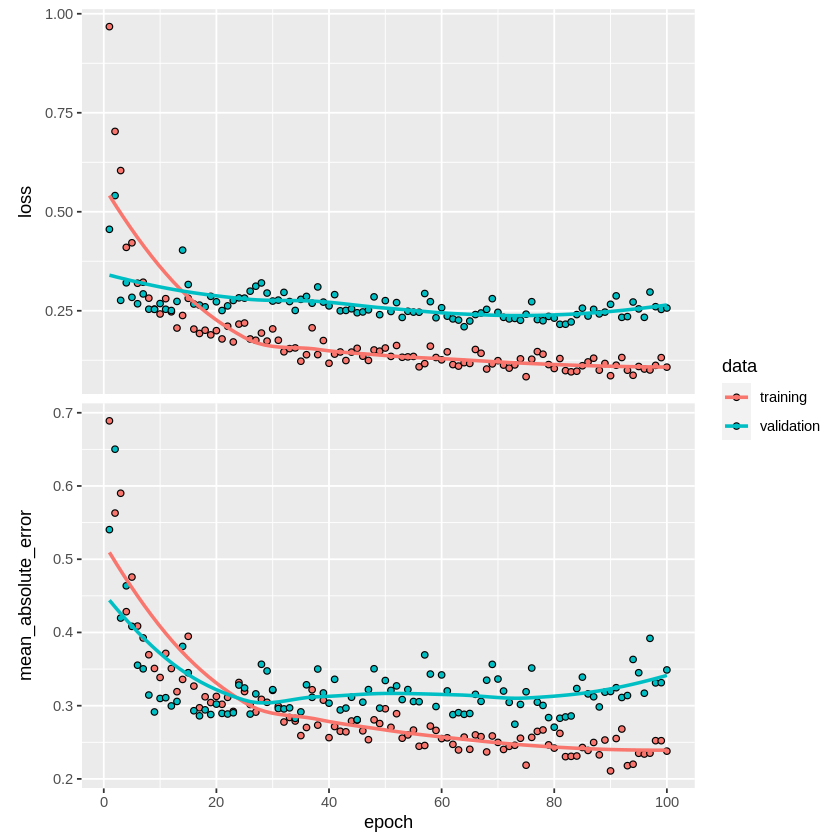

In [239]:
plot(history)

In [240]:
npred = predict(modnn, Xtest_stand)
yhat = npred *sd(Ytrain) + mean(Ytrain)
mse = mean((yhat - Ytest)^2)
mse

[1] 22.62308

the new MSE is 22.62, which is worth than the best boosting method.

Problem 2

In [ ]:
load("buzz_X1.RData")
load("buzz_X2.RData")
load("buzz_X3.RData")
load("buzz_X4.RData")
load("buzz_X5.RData")
load("buzz_X6.RData")
load("buzz_Y.RData")
X <- rbind(X1, X2, X3, X4, X5, X6)
str(X)
str(Y)
unique(Y)
# select training (90%) and validation samples (10%) randomly
set.seed(1)
trainInds <- sample(1:nrow(X), round(nrow(X)*0.9))
valInds <- (1:nrow(X))[-trainInds]
Xtrain <- X[trainInds, ]
Ytrain_classes <- Y[trainInds]
Xtest <- X[valInds, ]
Ytest_classes <- Y[valInds]
# rescale function to scale training X's between 0-1 (alternatively, you
# could standardize as we usually do by dividing by the standard deviation);
# Here is a little function to scale between 0-1; note, we have to apply
# the same transformation that was applied to the columns of Xtrain to the
# columns of Xtest.
rescaleCols <- function(rowX, colMins, colMaxs)
{
r <- (rowX - colMins)/(colMaxs - colMins)
r[is.nan(r)] <- 0
return(r)
}
colMinsX <- apply(Xtrain, 2, min)
colMaxsX <- apply(Xtrain, 2, max)
Xtrain_scaled <- t(apply(Xtrain, 1, rescaleCols, colMinsX, colMaxsX))
Xtest_scaled <- t(apply(Xtest, 1, rescaleCols, colMinsX, colMaxsX))
# it is good to look to see how the scaling worked - especially on
# the test set
range(Xtrain_scaled)
range(Xtest_scaled)
# convert the responses to factor variables
Ytrain <- as.factor(Ytrain_classes)
Ytest <- as.factor(Ytest_classes)


In [223]:
# reshape: vectorize
Xtrain_scaled = array_reshape(Xtrain_scaled, c(nrow(Xtrain_scaled), 2500))
Xtest_scaled = array_reshape(Xtest_scaled, c(nrow(Xtest_scaled), 2500))
Ytrain <- to_categorical(Ytrain, 10)
Ytest <- to_categorical(Ytest, 10)

In [224]:
# Define a model
model = keras_model_sequential() 

model %>% 
  layer_dense(units = 256, activation = 'relu', input_shape = c(2500)) %>%
  layer_dropout(rate = 0.4) %>% 
  layer_batch_normalization() %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_batch_normalization() %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_batch_normalization() %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_batch_normalization() %>%
  layer_dense(units = 10, activation = 'softmax')


# complie model
model %>% compile(loss = 'categorical_crossentropy', optimizer = optimizer_adam(),metrics = c('accuracy'))


loss  accuracy 
0.7702518 0.7283334

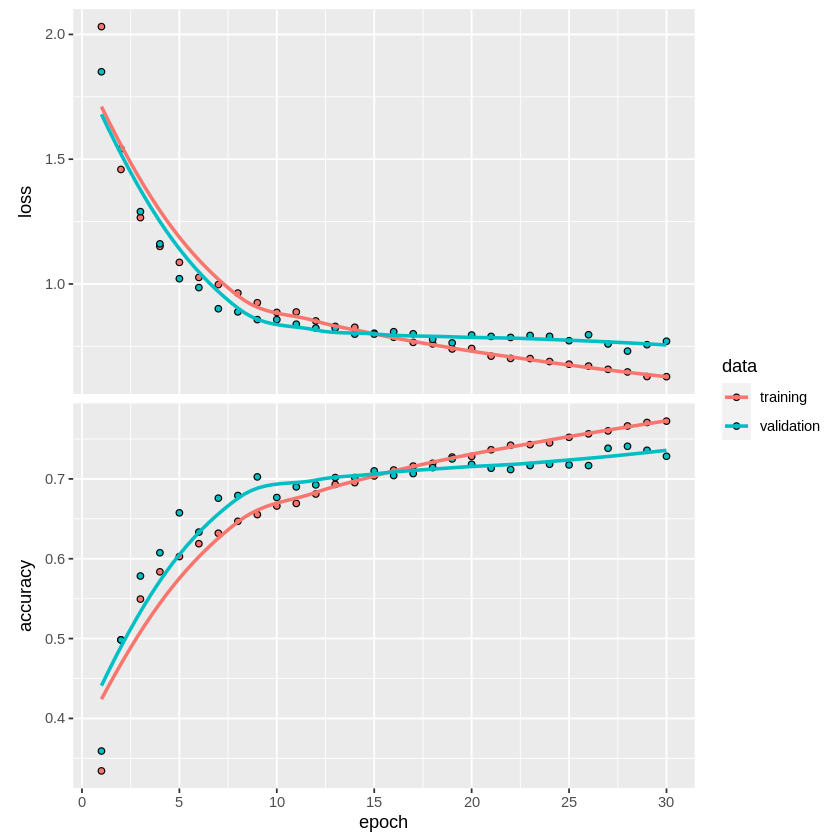

In [225]:
# History
history <- model %>% fit(
  Xtrain_scaled, Ytrain, 
  epochs = 30, 
  batch_size =  128, #256,
  validation_data = list(Xtest_scaled, Ytest))

plot(history)
model %>% evaluate(Xtest_scaled, Ytest)

I used the Multilayer Network with 5 layers and the accuracy is 72.8% 

In [226]:
# Define a model
model = keras_model_sequential() 

model %>% 
  layer_dense(units = 256, activation = 'relu', input_shape = c(2500)) %>%
  layer_dropout(rate = 0.4) %>% 
  layer_batch_normalization() %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_batch_normalization() %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_batch_normalization() %>%
  layer_dense(units = 64, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_batch_normalization() %>%
  layer_dense(units = 64, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_batch_normalization() %>%
  layer_dense(units = 10, activation = 'softmax')


# complie model
model %>% compile(loss = 'categorical_crossentropy', optimizer = optimizer_adam(),metrics = c('accuracy'))


loss  accuracy 
0.7796794 0.7316667

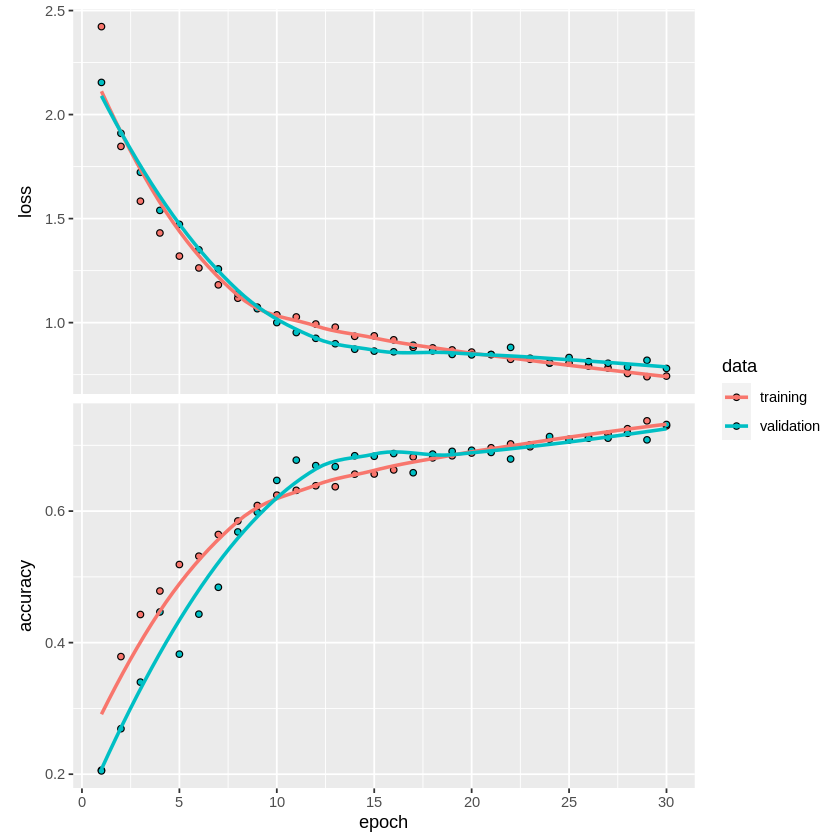

In [227]:
# History
history <- model %>% fit(
  Xtrain_scaled, Ytrain, 
  epochs = 30, 
  batch_size =  256,
  validation_data = list(Xtest_scaled, Ytest))

plot(history)
model %>% evaluate(Xtest_scaled, Ytest)

I changed the structure and parameters of the Multilayer Network with 6 layers and the accuracy is 73.2% 